In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import re
from collections import Counter
import plotly.express as px
import json
from URL_helper import URL_helper

df = pd.read_csv('/Users/eugenganenco/Desktop/srealtyAnalysis/DataWithCoordPrice.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
np.seterr(divide = 'ignore') 
print(df.shape)

(5999, 72)


### Analysis of the dependent variable 'price'

Because of the way I collected the data, every time a row has the price equal zero means that there was no value found.

In [2]:
def percentageMissing(feature):
    missingValues = df[feature].apply(lambda x: 1 if pd.isna(x) else 0).sum()
    return round((missingValues/len(df.axes[0])) * 100, 3)

data = df.copy()
missingValues = data.price.apply(lambda x: 1 if x == 0 else 0).sum()
percentageOfDf = round((missingValues/len(df.axes[0])) * 100, 3)
print('There are {} missing values in the dependent variable column. {}% of the data frame.'.format(missingValues, percentageOfDf))

There are 543 missing values in the dependent variable column. 9.052% of the data frame.


In [3]:
df = df.loc[df['price'] != 0]

I have eliminated all the instances where there was no value for the dependent variable.

In [4]:
print('Now the dependant variable has {}% missing.'.format(percentageMissing('price')))

Now the dependant variable has 0.0% missing.


In [5]:
print(f"Cheapest property found: {df['price'].min()} CZK")
print(f"Most expensive property found: {df['price'].max()} CZK")

Cheapest property found: 125000 CZK
Most expensive property found: 129000000 CZK


In [6]:
df.price.describe()

count    5.456000e+03
mean     7.276832e+06
std      7.705617e+06
min      1.250000e+05
25%      2.990000e+06
50%      5.025000e+06
75%      8.850200e+06
max      1.290000e+08
Name: price, dtype: float64

In [7]:
df.loc[df['price'] == df['price'].max(),['link', 'location']]

link  \
3560  https://www.sreality.cz/detail/prodej/dum/undefined/praha-mala-strana-malostranske-namesti/737057116   

                                       location  
3560  Malostranské náměstí, Praha - Malá Strana

In [8]:
df.loc[df['price'] == df['price'].min(),['link', 'location']]

link  \
3972  https://www.sreality.cz/detail/prodej/dum/chata/praha-horni-pocernice-nachodska/1943766604   

                                  location  
3972  Náchodská, Praha 9 - Horní Počernice

These are the most expensive and the cheapest properties on the market respectively.

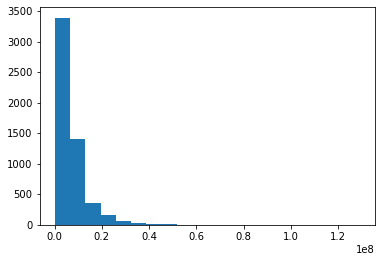

In [9]:
plt.hist(df['price'], bins=20)
plt.show()

The histogram above indicates a high degree of sqewness for the dependent variable. Could use some normalization.

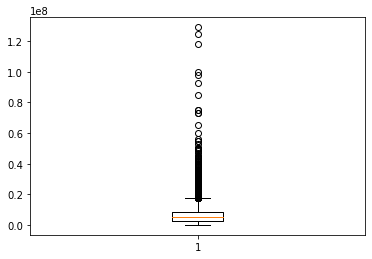

In [10]:
_ = plt.boxplot(df['price'])

We notice a lot of outliers.

In [11]:
def getOutliersList(feature):
    featureList = np.array(df[feature].tolist())
    featureList = featureList[~np.isnan(featureList)]
    upperQuartile = np.percentile(featureList, 75)
    lowerQuartile = np.percentile(featureList, 25)
    IQR = (upperQuartile - lowerQuartile) * 1.5
    resultList = []
    for observation in featureList:
        if observation >= upperQuartile + IQR or observation <= lowerQuartile - IQR:
            resultList.append(observation)
    return resultList

print(f"There are {len(getOutliersList('price'))} outliers in the 'price' column.")

There are 373 outliers in the 'price' column.


## Analysis of the independent variables

<AxesSubplot:>

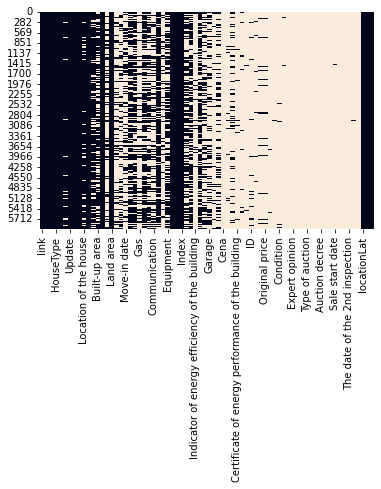

In [12]:
sns.heatmap(df.isnull(), cbar=False)

Many columns are very sparsely populated. Cells painted with beige are null.

In [13]:
data = df.copy()
featureList = []
for feature in data.columns:
    if percentageMissing(feature) >= 90:
        featureList.append(feature)
print('The following features have more than 90% missing data:\n')
print(featureList)    

The following features have more than 90% missing data:

['Indicator of energy efficiency of the building', 'Year of reconstruction', 'Cena', 'Year of approval', 'Certificate of energy performance of the building', 'Swimming pool', 'Number of flats', 'ID', 'Housing costs', 'Discounted', 'Original price', 'Pool area', 'Ceiling height', 'Condition', 'Soil construction', 'Starting price', 'Expert opinion', 'Minimum bid', 'Auction principal', 'Type of auction', 'Place of auction', 'The date of the auction', 'Auction decree', 'Expert opinion.1', 'Inspection date', 'Sale start date', 'Minimum purchase price', 'The date of the 1st inspection', 'The date of the 2nd inspection', 'Date of completion of construction', 'Inspection date to']


### Relationship between missing variables and the dependent variable

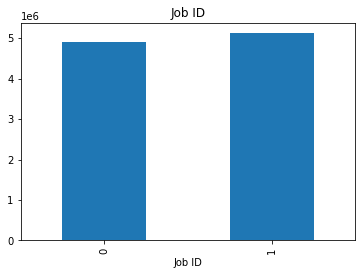

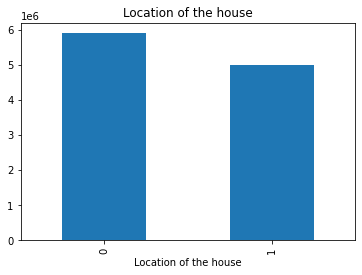

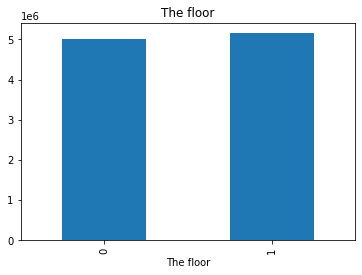

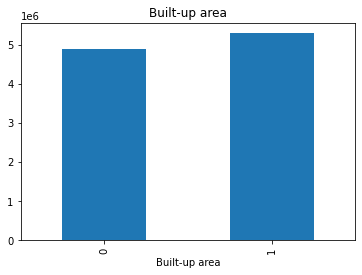

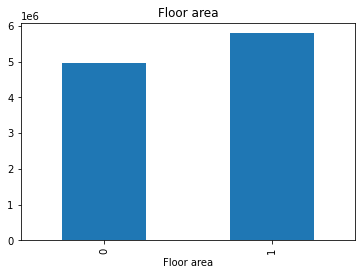

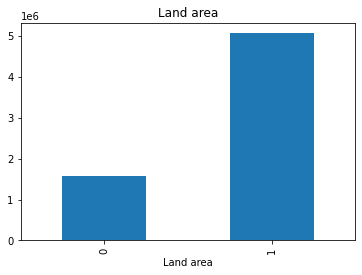

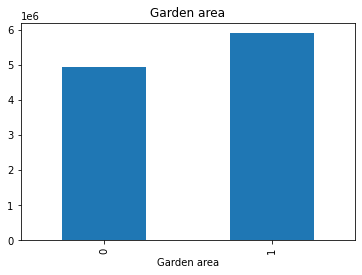

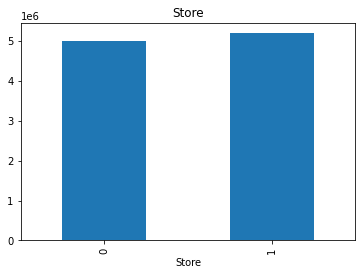

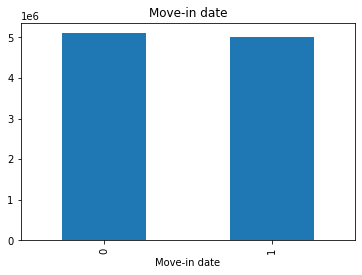

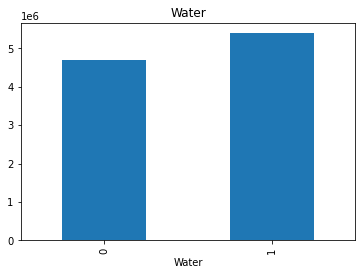

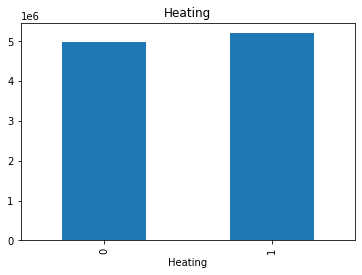

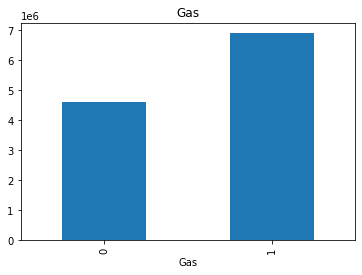

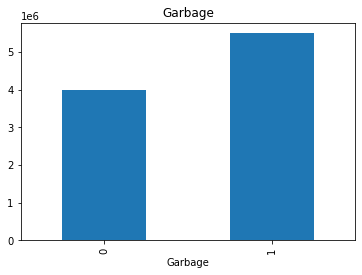

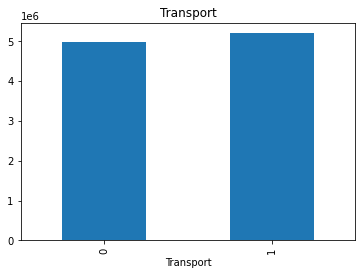

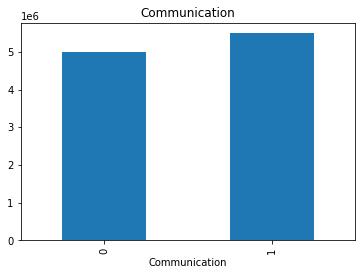

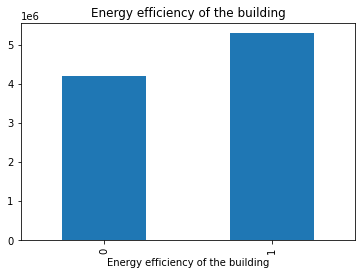

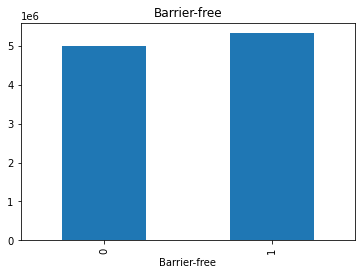

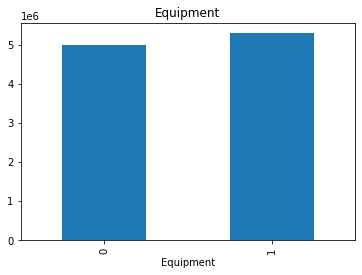

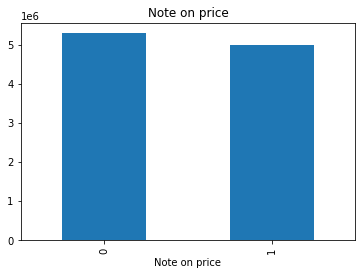

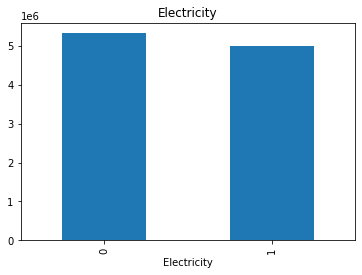

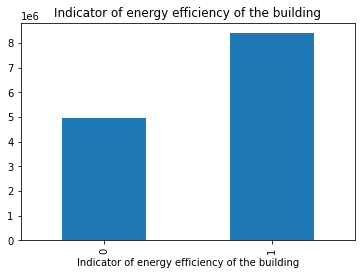

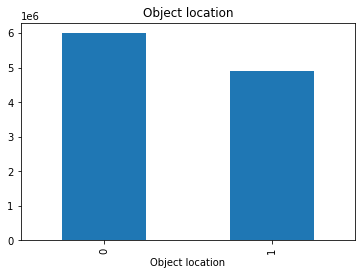

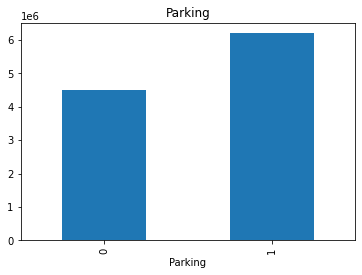

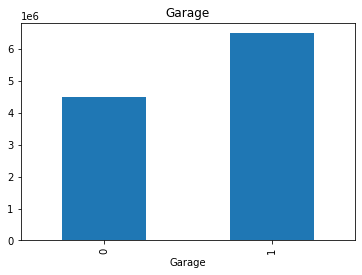

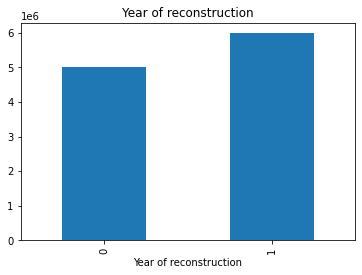

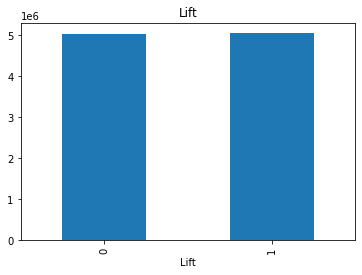

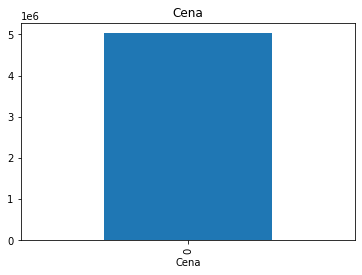

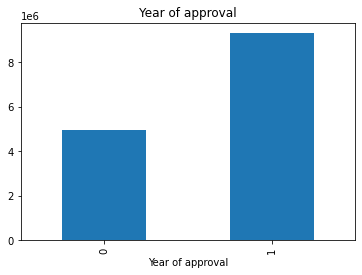

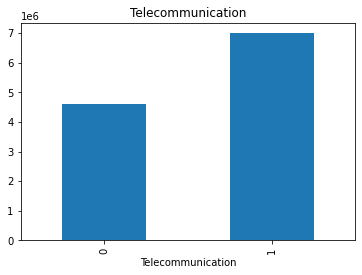

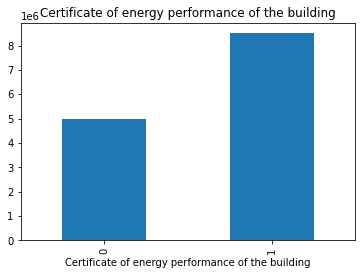

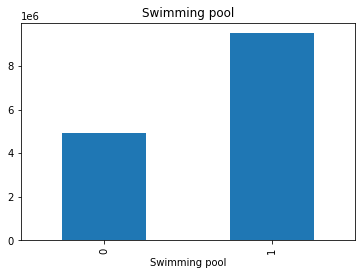

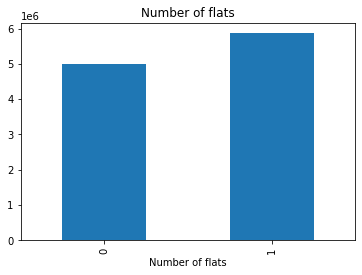

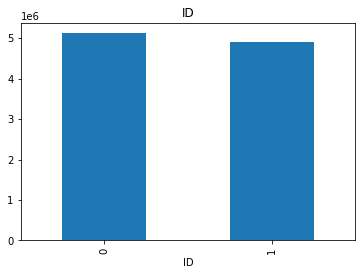

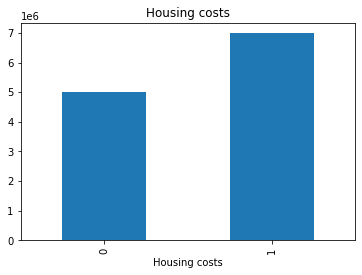

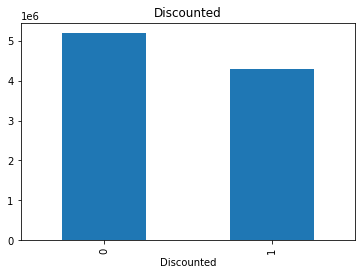

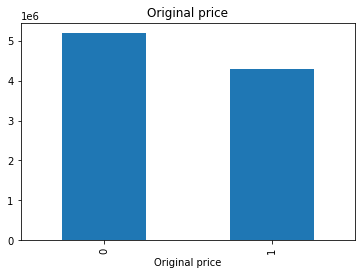

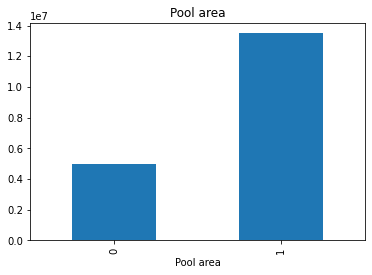

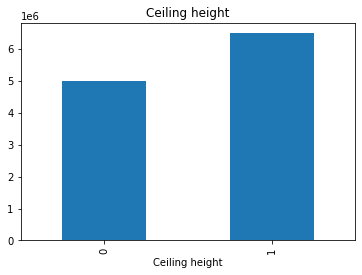

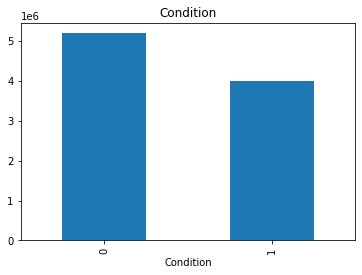

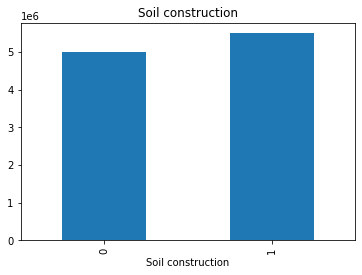

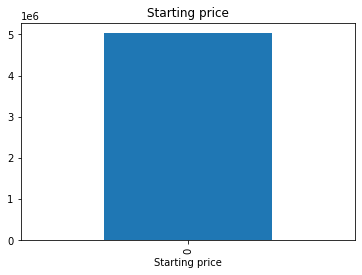

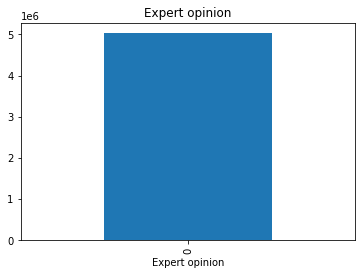

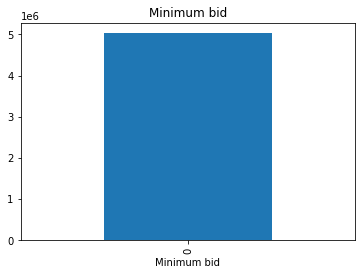

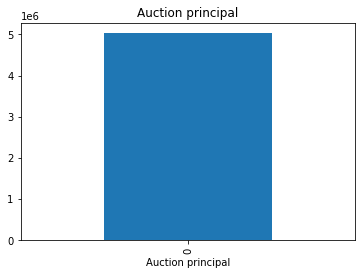

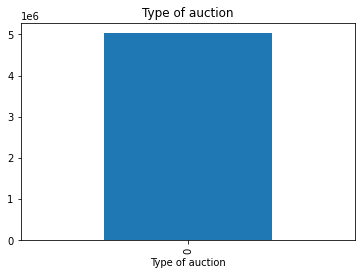

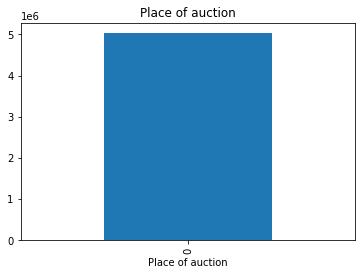

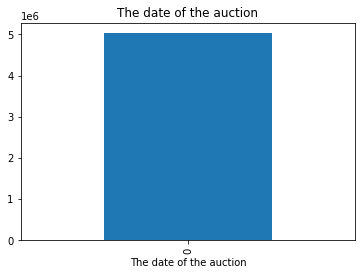

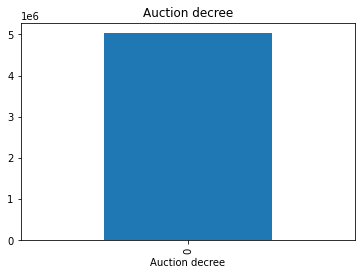

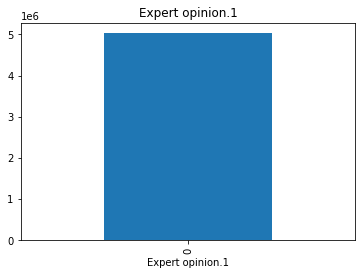

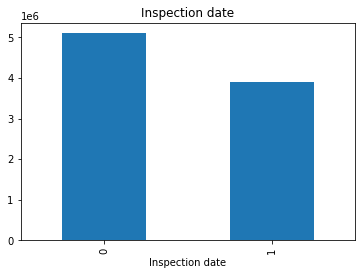

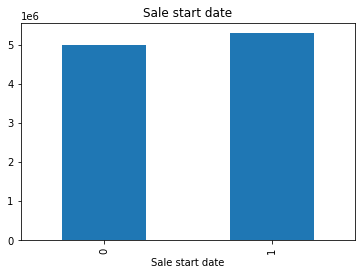

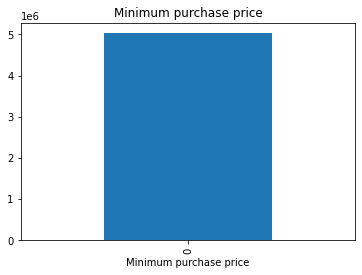

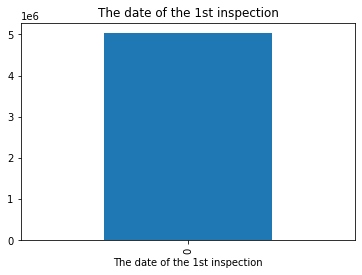

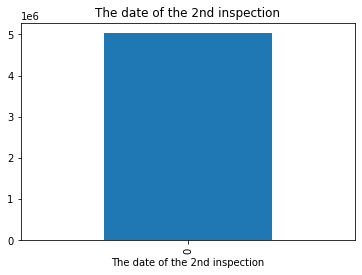

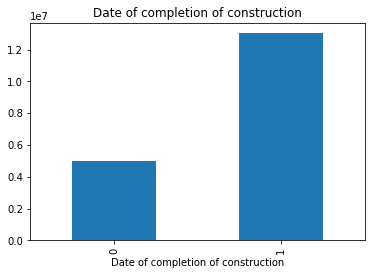

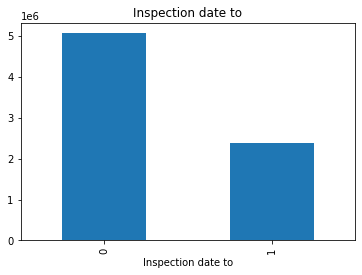

In [14]:
featuresWithMissing = [feature for feature in df.columns if df[feature].isnull().sum() > 1]
for feature in featuresWithMissing:
    data = df.copy()
    data[feature] = np.where(data[feature].notnull(), 1, 0)
    data.groupby(feature)['price'].median().plot.bar()
    plt.title(feature)
    plt.show()

There is a visible relationship between many of the missing values and the target variable. 

### Numerical variables

In [15]:
numbericalFeatures = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical features is: {} out of {}.'.format(len(numbericalFeatures), len(df.columns)))
df[numbericalFeatures].head(5)
for feature in numbericalFeatures:
    print('Percentage of missin values for "{}" variabel is: {}'.format(feature,percentageMissing(feature)))

Number of numerical features is: 13 out of 72.
Percentage of missin values for "Barrier-free" variabel is: 80.334
Percentage of missin values for "proximityIndex" variabel is: 0.0
Percentage of missin values for "Index" variabel is: 0.0
Percentage of missin values for "Parking" variabel is: 57.991
Percentage of missin values for "Garage" variabel is: 67.742
Percentage of missin values for "Year of reconstruction" variabel is: 90.158
Percentage of missin values for "Lift" variabel is: 66.202
Percentage of missin values for "Year of approval" variabel is: 93.493
Percentage of missin values for "Swimming pool" variabel is: 93.548
Percentage of missin values for "Number of flats" variabel is: 99.12
Percentage of missin values for "ID" variabel is: 92.467
Percentage of missin values for "Soil construction" variabel is: 98.552
Percentage of missin values for "price" variabel is: 0.0


### Relationship between year variables and price of houses

In [16]:
yearFeatures = [feature for feature in numbericalFeatures if 'yr' in feature.lower() or 'year' in feature.lower()]
print(yearFeatures)

['Year of reconstruction', 'Year of approval']


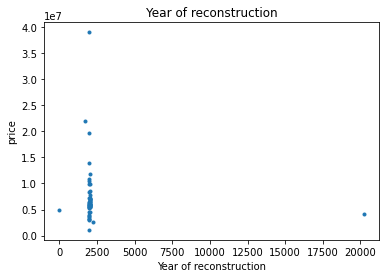

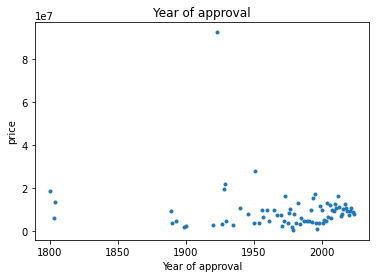

In [17]:
for feature in yearFeatures:
    df.groupby(feature)['price'].median().plot(style='.')
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

These are the graphs with year features containning outliers.

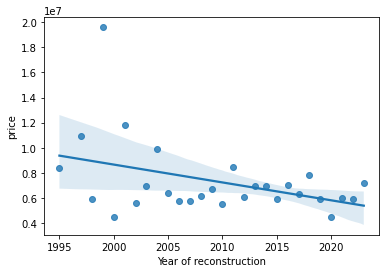

count      537.000000
mean      2042.117318
std        791.051751
min          2.000000
25%       2010.000000
50%       2017.000000
75%       2021.000000
max      20223.000000
Name: Year of reconstruction, dtype: float64


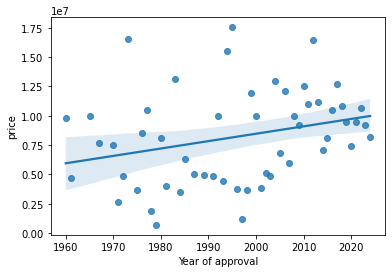

count     355.000000
mean     2000.016901
std        33.788721
min      1800.000000
25%      1995.500000
50%      2011.000000
75%      2021.000000
max      2024.000000
Name: Year of approval, dtype: float64


In [18]:
for feature in yearFeatures:
    outlierList = getOutliersList(feature)
    featureSeries = df.loc[~df[feature].isin(outlierList), :].groupby(feature)['price'].median()
    sns.regplot(x=featureSeries.index, y=featureSeries)
    plt.show()
    print(df[feature].describe())

These are the graphs we get when we eliminate the outliers.

### Discrete variables

In [19]:
discreteVariables = [feature for feature in numbericalFeatures if len(df[feature].unique()) < 30 and feature not in yearFeatures]
print(discreteVariables)

['Barrier-free', 'Parking', 'Lift', 'Swimming pool', 'Number of flats', 'Soil construction']


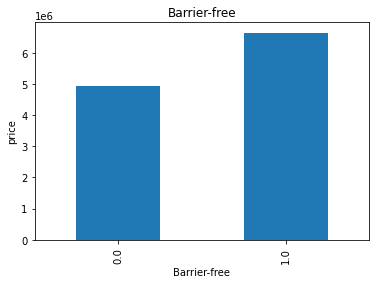

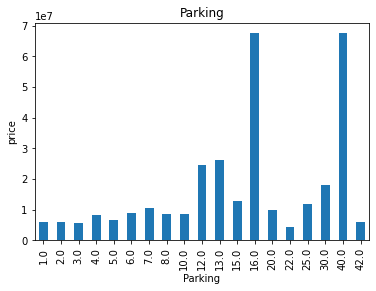

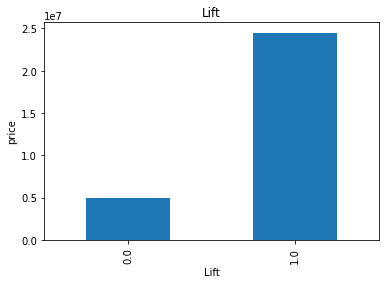

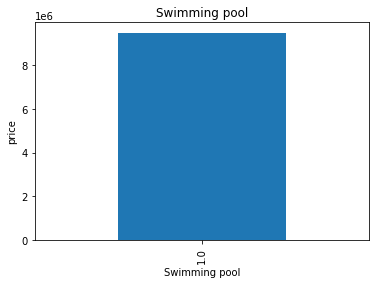

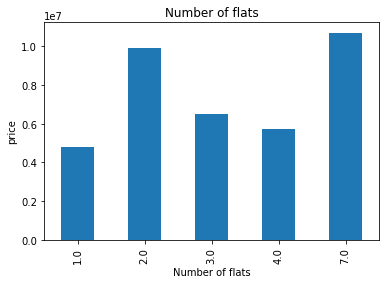

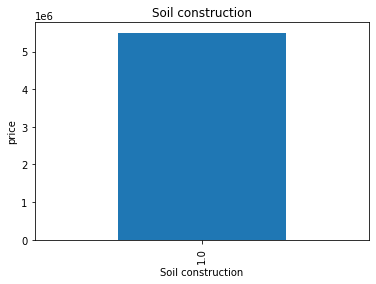

In [20]:
for feature in discreteVariables:
    data = df.copy()
    data.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### Continuous features

In [21]:
continuousFeatures = [feature for feature in numbericalFeatures if feature not in discreteVariables + yearFeatures + ['Index', 'ID', 'price']]
print(continuousFeatures)

['proximityIndex', 'Garage']


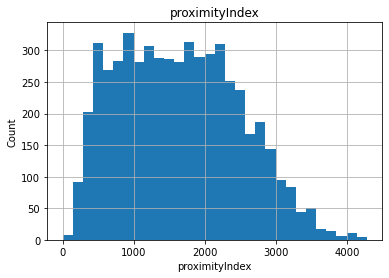

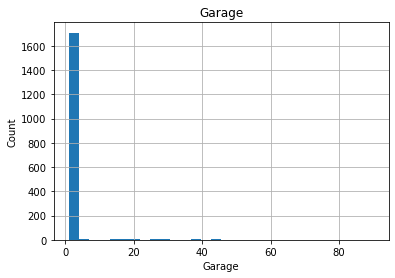

In [22]:
for feature in continuousFeatures:
    data = df.copy()
    data[feature].hist(bins=30)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
/Applications/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


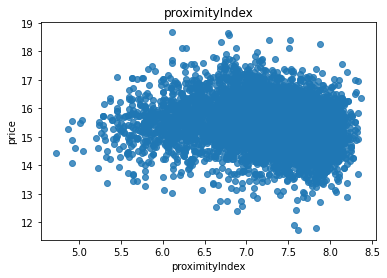

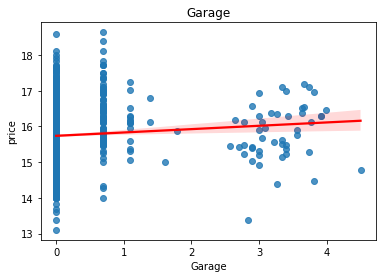

In [23]:
for feature in continuousFeatures:
    data = df.copy()
    data[feature] = np.log(data[feature])
    data['price'] = np.log(data['price'])
    sns.regplot(x=data[feature], y=data['price'], line_kws={"color": "red"})
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### Categorical features

In [24]:
categoricalFeatures = [feature for feature in df.columns if df[feature].dtypes == 'O']
print(categoricalFeatures)

['link', 'location', 'district', 'HouseType', 'total price', 'Job ID', 'Update', 'Building', 'Object status', 'Location of the house', 'Home type', 'The floor', 'Built-up area', 'Usable area', 'Floor area', 'Land area', 'Garden area', 'Store', 'Move-in date', 'Water', 'Heating', 'Gas', 'Garbage', 'Transport', 'Communication', 'Energy efficiency of the building', 'Equipment', 'companyName', 'Note on price', 'Electricity', 'Indicator of energy efficiency of the building', 'Object location', 'Cena', 'Telecommunication', 'Certificate of energy performance of the building', 'Housing costs', 'Discounted', 'Original price', 'Pool area', 'Ceiling height', 'Condition', 'Starting price', 'Expert opinion', 'Minimum bid', 'Auction principal', 'Type of auction', 'Place of auction', 'The date of the auction', 'Auction decree', 'Expert opinion.1', 'Inspection date', 'Sale start date', 'Minimum purchase price', 'The date of the 1st inspection', 'The date of the 2nd inspection', 'Date of completion of 

In [25]:
for feature in categoricalFeatures:
    print('The feature is "{}". Number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is "link". Number of categories are 5456
The feature is "location". Number of categories are 3932
The feature is "district". Number of categories are 61
The feature is "HouseType". Number of categories are 8
The feature is "total price". Number of categories are 1644
The feature is "Job ID". Number of categories are 4924
The feature is "Update". Number of categories are 167
The feature is "Building". Number of categories are 7
The feature is "Object status". Number of categories are 10
The feature is "Location of the house". Number of categories are 5
The feature is "Home type". Number of categories are 2
The feature is "The floor". Number of categories are 47
The feature is "Built-up area". Number of categories are 601
The feature is "Usable area". Number of categories are 643
The feature is "Floor area". Number of categories are 383
The feature is "Land area". Number of categories are 2041
The feature is "Garden area". Number of categories are 883
The feature is "Store". 

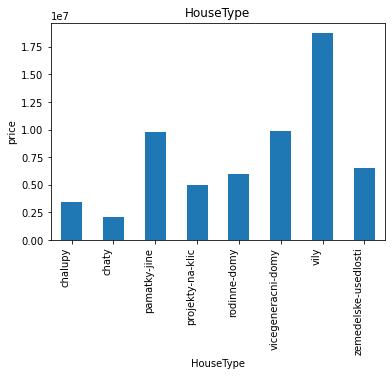

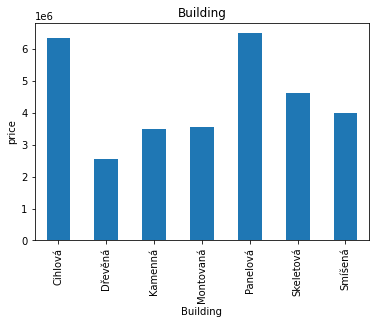

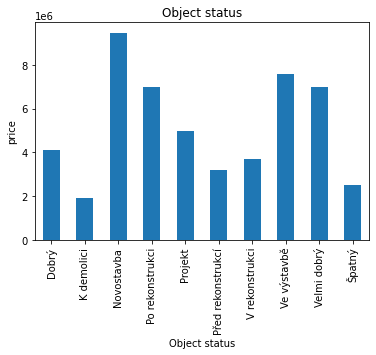

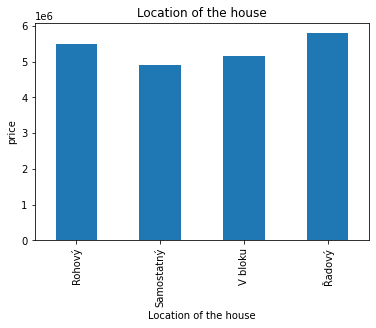

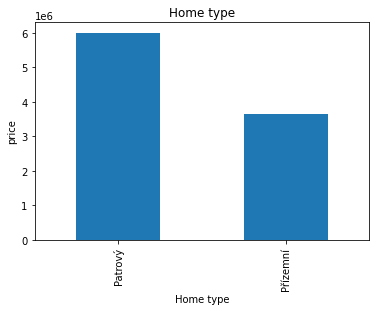

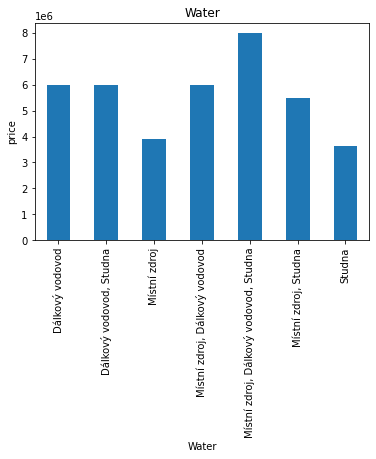

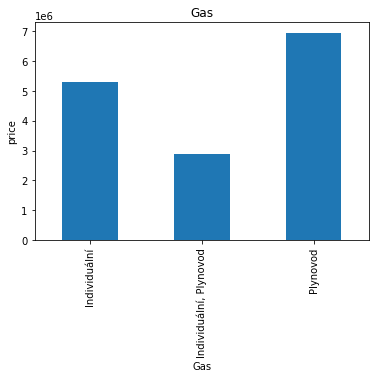

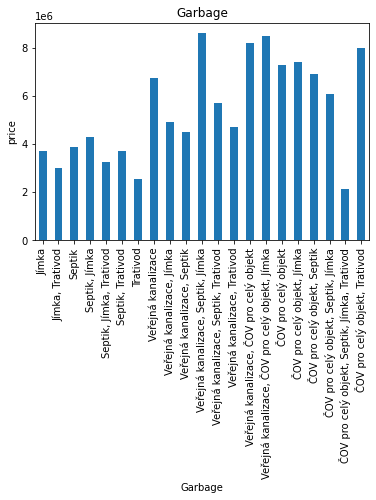

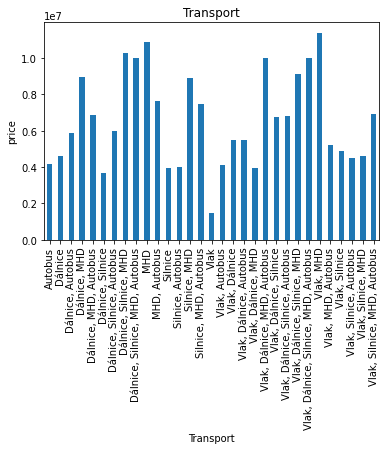

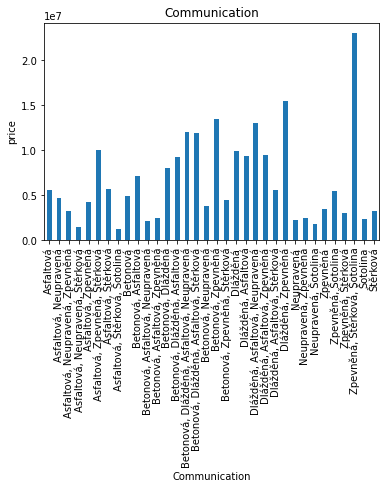

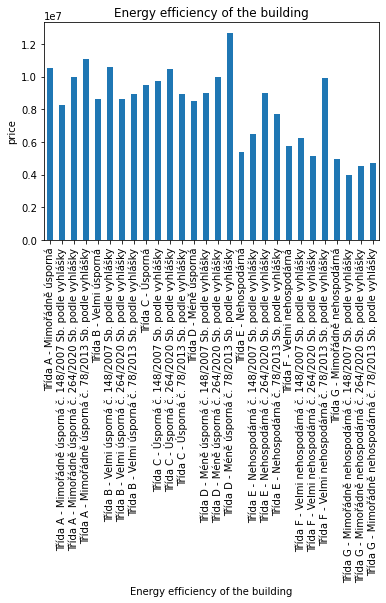

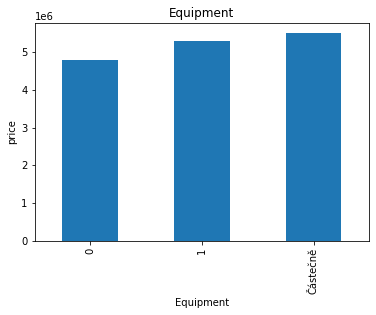

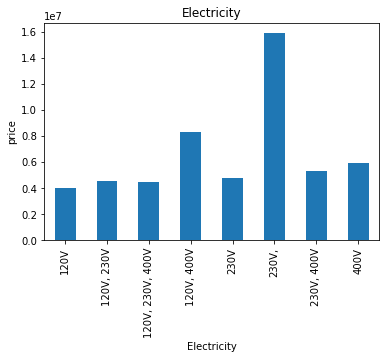

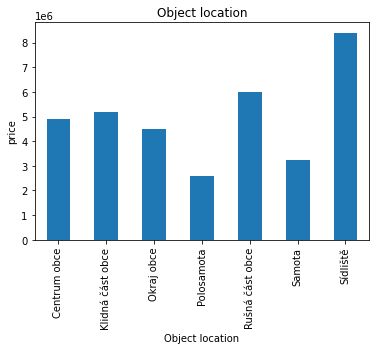

IndexError: index 0 is out of bounds for axis 0 with size 0

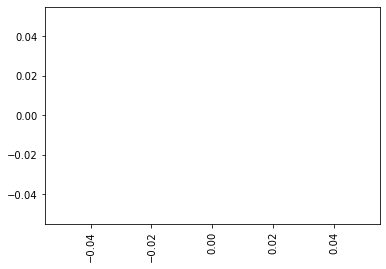

In [35]:
data = df.copy()
categoricalFeatures = [feature for feature in data.columns if feature not in numbericalFeatures and len(data[feature].unique()) <= 35]
categoricalFeatures = categoricalFeatures[:-11]
for feature in categoricalFeatures:
    data.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()


### Map of the Czech Republic with the average price of property being sold per NUTS 4 region.

In [27]:
czechStates = json.load(open('geoJsonCZ.json', 'r'))
czechStates['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[14.56924461704827, 50.00770879957661],
    [14.534995811950823, 50.0114772445781],
    [14.393345768303185, 49.952517282092586],
    [14.345847384894167, 49.94727171895303],
    [14.33880567277518, 49.98049139096107],
    [14.296061152888404, 50.002024441137266],
    [14.271127862446134, 50.03965596360334],
    [14.25937514380102, 50.10043274550602],
    [14.316258327373454, 50.12839885596487],
    [14.359078279683196, 50.11598765248309],
    [14.365589647853326, 50.1481991545729],
    [14.401072379953709, 50.1479349371616],
    [14.46673359236424, 50.16938602301883],
    [14.533544563410173, 50.17686790571296],
    [14.610808414188728, 50.12667002763059],
    [14.658801088509474, 50.12282344095549],
    [14.665945478445733, 50.103183216955685],
    [14.706571427483144, 50.08722630297063],
    [14.641226225810158, 50.05720943085254],
    [14.66919214143369, 50.01927774803277],
    [14.640195000385926, 50.005843552

In [28]:
czechLocationsMap = {}
for feature in czechStates['features']:
    feature['id'] = feature['properties']['NUTS4']
    czechLocationsMap[feature['properties']['name']] = feature['id']

In [31]:
locationsSet = URL_helper().getLocationsSet()
locationsSet.remove('praha')
locationsSet.add('praha')

In [32]:
czechLocationsMap = {}
for feature in czechStates['features']:
    feature['id'] = feature['properties']['NUTS4']
    czechLocationsMap[feature['properties']['name']] = feature['id']

def findCorrespondingString(string, stringSet):
    if 'město' in string:
        string = string.replace('-město', '$')
    if ' n.' in string:
        string = string.replace(' n.', '-nad-') 
    charList = ['^']
    reg = re.compile(r'[a-zA-Z-]')
    for c in string:
        if c == '$':
            if charList[-1] == '*':
                charList = charList[0:len(charList)-1]
            break
        if reg.match(c):
            charList.append(c)
        else:
            charList.append('.')
            charList.append('*')
    if charList[-1] != '$':
        charList.append('$')
    string = ''.join(charList).lower()
    reg = re.compile(string)
    for s in stringSet:
        if reg.search(s.lower()):
            return s
    return 'Unknown'

for location in list(czechLocationsMap):
    # map location to the corresponding one in df
    val = czechLocationsMap[location]
    czechLocationsMap.pop(location)
    location = findCorrespondingString(location, locationsSet)
    czechLocationsMap[location] = val
    
print(czechLocationsMap)
print(len(locationsSet))

{'praha': 'CZ0110', 'benesov': 'CZ0211', 'beroun': 'CZ0212', 'kladno': 'CZ0213', 'kolin': 'CZ0214', 'kutna-hora': 'CZ0215', 'melnik': 'CZ0216', 'mlada-boleslav': 'CZ0217', 'nymburk': 'CZ0218', 'praha-vychod': 'CZ0219', 'praha-zapad': 'CZ021A', 'pribram': 'CZ021B', 'rakovnik': 'CZ021C', 'ceske-budejovice': 'CZ0311', 'cesky-krumlov': 'CZ0312', 'jindrichuv-hradec': 'CZ0313', 'pelhrimov': 'CZ0613', 'pisek': 'CZ0314', 'prachatice': 'CZ0315', 'strakonice': 'CZ0316', 'tabor': 'CZ0317', 'domazlice': 'CZ0321', 'cheb': 'CZ0411', 'karlovy-vary': 'CZ0412', 'klatovy': 'CZ0322', 'plzen': 'CZ0323', 'plzen-jih': 'CZ0324', 'plzen-sever': 'CZ0325', 'rokycany': 'CZ0326', 'sokolov': 'CZ0413', 'tachov': 'CZ0327', 'ceska-lipa': 'CZ0511', 'decin': 'CZ0421', 'chomutov': 'CZ0422', 'jablonec-nad-nisou': 'CZ0512', 'liberec': 'CZ0513', 'litomerice': 'CZ0423', 'louny': 'CZ0424', 'most': 'CZ0425', 'teplice': 'CZ0426', 'usti-nad-labem': 'CZ0427', 'havlickuv-brod': 'CZ0611', 'hradec-kralove': 'CZ0521', 'chrudim': 'CZ

In [33]:
df['id'] = df['district'].apply(lambda x: czechLocationsMap['praha'] if bool(re.search(r'\d', x)) else czechLocationsMap[x])
len(df['id'].unique())

53

In [34]:
data = df.groupby('id')['price'].apply(np.average)
data = data.to_frame()
data['N4'] = data.index
czechLocationsMapInversed = {v: k for k, v in czechLocationsMap.items()}
data['locationName'] = data['N4'].map(czechLocationsMapInversed)
fig = px.choropleth(data, locations='N4', geojson=czechStates, color='price', hover_name='locationName')
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [ ]:
df.loc[df.id == 'CZ0110', 'price'].hist(bins=20)

Price distribution of properties sold in Prague.

In [ ]:
totalValueSeries = df.groupby('companyName')['price'].sum().sort_values(ascending=False)
valueCompanies = totalValueSeries.head(5)
otherCompanies = totalValueSeries.tail(totalValueSeries.count() - 5).sum()
valueCompanies.loc['Other Companies'] = otherCompanies
print(valueCompanies)
plt.pie(valueCompanies)
plt.legend(valueCompanies.index, loc='best')
plt.show()

These are the top companies in Czech Republic by the total value of the properties they are selling.

In [ ]:
countSeries = df.groupby('companyName')['link'].count().sort_values(ascending=False)
print(countSeries.head(5))
countSeries.head(10).plot.bar()

These are the top companies in Czech Republic by the number of the houses they are selling (assuming that every posting refers to a different property).

In [ ]:
(totalValueSeries / countSeries).sort_values(ascending=False)

These are top companies in Czech Republic by the average price of the property their are selling.

## Below I will transform various features to make them usable for further analysis

### 1. "Floor" variable: 

In [ ]:
df['The floor'].unique()

In [ ]:
print('Percentage of rows with non-missing "The Floor" variable: {}'.format(percentageMissing('The floor')))

Users of the site "Srealty" do not use the field "Podlaži" in a consistent and predictable manner. Those who sell single-family homes use this variable to indicate the number of floors their property has, those who live in flats - the floor their flat is located.

### 2. Build-up area, Usable area, Floor Area, Land Area, Garden Area variables

In [ ]:
def extractInt(string):
    charList = []
    for c in string:
        if c.isdigit():
            charList.append(c)
        else:
            break
    return int("".join(charList))

featureList = ['Built-up area', 'Usable area', 'Floor area', 'Land area', 'Garden area']
featuresModified = df.loc[:,featureList].applymap(extractInt, na_action='ignore')

for feature in featureList:
    df[feature] = featuresModified[feature].values
print(df.loc[:,featureList])

In [ ]:
corr = df.loc[:,featureList].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [ ]:
for feature in featureList:
    data = df.copy()
    data[feature] = np.log(data[feature])
    data['price'] = np.log(data['price'])
    sns.regplot(x=data[feature], y=data['price'], line_kws={"color": "red"})
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### 3. "Store" variable.

In [ ]:
print('Percentage of rows with non-missing "Store" variable: {}'.format(percentageMissing('Store')))

In [ ]:
df['Storage area'] = df['Store'].apply(lambda x: x if x != '1' else '0') # 0 will mean unknown
df['Storage area'] = df['Storage area'].str.replace(r'\s.*', '', regex=True)
df['Store'] = df['Store'].notnull().astype('int')

In [ ]:
print(df['Store'].head())

In [ ]:
sns.regplot(x=pd.to_numeric(df['Storage area'], errors='coerce'), y=data['price'], line_kws={"color": "red"})
plt.xlabel('Storage area')
plt.ylabel('price')
plt.title('Storage area')
plt.show()

In [ ]:
df.groupby('Store')['price'].median().plot.bar()
plt.title('Store')
plt.show()

Variable "Store" will indicate if the property has a storage unit. "Storage area" will denote the area of that storage unit if provided.

### 4. Energy efficiency of the building variable

In [ ]:
df['Energy efficiency of the building'] = df['Energy efficiency of the building'].map(lambda x: x[6], na_action='ignore')
print(df['Energy efficiency of the building'])

In [ ]:
df.groupby('Energy efficiency of the building')['price'].median().plot.bar()
plt.title('Energy efficiency of the building')
plt.show()

### 5. Note on price variable

In [ ]:
len(df['Note on price'].unique())

In [ ]:
print('Percentage of rows with non-missing "Note on price" variable: {}'.format(percentageMissing('Note on price')))

In [ ]:
notesDict = Counter()
notesList = df['Note on price'].tolist()
for note in notesList:
    if pd.isna(note):
        continue
    notesDict.update([string.lower().lstrip() for string in re.split(',|;|/.', note)])
print(notesDict)

The dictionary above sorts the types of notes found in 'Note on price' variable by frequency of occurance.

In [ ]:
df['Note on price'].fillna('Nothing', inplace=True)
df.loc[df['Note on price'].str.contains('poplatků', re.IGNORECASE), ['Note on price']]

Next I will try to extract from the 'Note on price' variable the information about whether the house price includes comission, legal fees, vat, fees and if the price is negotiable.

In [ ]:
def followsPattern(text, pattern):
        if re.search(pattern, text.lower().lstrip()):
            return True
        else:
            return False

notelist = ['provize', 'právního', 'dph', 'poplatků']
patternList = []

for note in notelist:
    patternList.append(re.compile('.*(včetně|\+)\s?.*{}.*'.format(note)))
patternList.append(re.compile('.*cena k jednání'))
notelist.append('cena k jednání')

for note,patternToFollow in zip(notelist,patternList):
    df[note] = df.loc[df['Note on price'].apply(followsPattern, pattern=patternToFollow),'Note on price'].map(lambda x: 'True', na_action='ignore')

In [ ]:
for feature in notelist:
    data = df.copy()
    data[feature] = np.where(data[feature].notnull(), 1, 0)
    data.groupby(feature)['price'].median().plot.bar()
    plt.title(feature)
    plt.show()

The interesting part here is that the houses where the price is negotiable (cena k jendnani) cost more than those that do not indicate the possibility of negotiation. 

### 6. Electricity variable

In [ ]:
print(df['Electricity'].unique())

### 6. "Lift" variable:

In [ ]:
df.groupby('Lift')['Index'].count()

In [ ]:
df['Lift'].count()/len(df.axes[0])

Find how much different are the houses with 'lift = 1' from the median in term of price.

In [ ]:
df.loc[df['Lift'] == 1.0, ['price']].describe()

In [ ]:
# df.loc[df.education == '9th', 'education'].count()
df.loc[df['Lift'] == 1, 'Index'].count()

In [ ]:
dataWithLift = df.loc[df['Lift'] == 1.0, ['price']]
plt.hist(dataWithLift, bins=15)
plt.show()

print('Median price for all properties is: {}'.format(round(df['price'].mean())))
print('Median price for all properties with lift is: {}'.format(round(dataWithLift['price'].mean())))

# if the sample size is larger than 30, use Z-test.
if df.loc[df['Lift'] == 1, 'Index'].count() <= 30:
    stat, p = ttest_ind(dataWithLift, df['price'])
    print('p-value for t-test: {}'.format(p))
else:
    stat, p = ztest(dataWithLift, df['price']) 
    print('p-value for z-test: {}'.format(p))

Given the small p-value the difference between the means are statistically signifficant. 